<a href="https://colab.research.google.com/github/AITrading1995/AITrading1995/blob/main/EUR/USDCHF_pair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tvDatafeed import TvDatafeed,Interval

In [116]:


def get(symbols, exchange, time, bar):
    def data(symbol):
        tv = TvDatafeed()  # หรือ login ถ้ามี username/password
        time_map = {
            '1m': Interval.in_1_minute,
            '5m': Interval.in_5_minute,
            '15m': Interval.in_15_minute,
            '30m': Interval.in_30_minute,
            '1h': Interval.in_1_hour,
            '4h': Interval.in_4_hour,
            'D': Interval.in_daily,
            'W': Interval.in_weekly
        }

        try:
            df = tv.get_hist(symbol=symbol, exchange=exchange,
                             interval=time_map[time], n_bars=bar)
            if df is None or df.empty:
                print(f'❌ No data for {symbol}, skipping...')
                return None
            return df.drop(columns='symbol')
        except Exception as e:
            print(f'⚠️ Error getting data for {symbol}: {e}')
            return None

    # ดึงข้อมูลแบบข้าม None
    all_data = []
    passed_symbols = []

    for symbol in symbols:
        result = data(symbol)
        if result is not None:
            all_data.append(result)
            passed_symbols.append(symbol)

    if not all_data:
        raise ValueError("❌ No valid data fetched for any symbols.")

    return pd.concat(all_data, keys=passed_symbols, names=['Ticker', 'date'])

In [ ]:
symbols =['XAUUSD','EURUSD','USDJPY','NZDJPY',
         'USDCAD','GBPJPY','EURGBP',
          'USDTHB','US30USD','AUDNZD','USDCHF']
time = '5m'
exchange='OANDA'
bar = 96*252
df = get(symbols, exchange, time, bar)

In [55]:
symbols = df.index.get_level_values('Ticker').unique()
print(symbols)

Index(['XAUUSD', 'EURUSD', 'USDJPY', 'NZDJPY', 'USDCAD', 'GBPJPY', 'EURGBP',
       'USDTHB', 'US30USD', 'AUDNZD', 'USDCHF'],
      dtype='object', name='Ticker')


In [118]:
# Step 1: เลือกเฉพาะ column 'close'
df_close = df[['close']]

# Step 2: Pivot เพื่อเปลี่ยนจาก multi-index เป็น wide format
df_close_wide = df_close.reset_index().pivot(index='date', columns='Ticker', values='close')

# Step 3: ตรวจสอบผลลัพธ์
print(df_close_wide.head())

Ticker               AUDNZD   EURGBP   EURUSD   GBPJPY  NZDJPY  US30USD  \
date                                                                      
2025-05-04 21:00:00  1.0846  0.85206  1.13062  191.950  85.963      NaN   
2025-05-04 21:05:00     NaN  0.85240  1.13081  191.938     NaN      NaN   
2025-05-04 21:10:00     NaN  0.85221  1.13035  191.938     NaN      NaN   
2025-05-04 21:15:00     NaN  0.85224  1.13038  191.942     NaN      NaN   
2025-05-04 21:20:00     NaN  0.85228  1.13048  192.060     NaN      NaN   

Ticker                USDCAD   USDCHF   USDJPY  USDTHB  XAUUSD  
date                                                            
2025-05-04 21:00:00  1.37995  0.82821  144.732  33.094     NaN  
2025-05-04 21:05:00  1.37989      NaN  144.711     NaN     NaN  
2025-05-04 21:10:00  1.38018  0.82594  144.720  33.088     NaN  
2025-05-04 21:15:00  1.38032  0.82608  144.728     NaN     NaN  
2025-05-04 21:20:00  1.37997  0.82617  144.816  33.094     NaN  


In [120]:
dfs =df_close_wide

In [121]:
re=dfs.dropna()

In [59]:
log_return = np.log(re/re.shift(1))

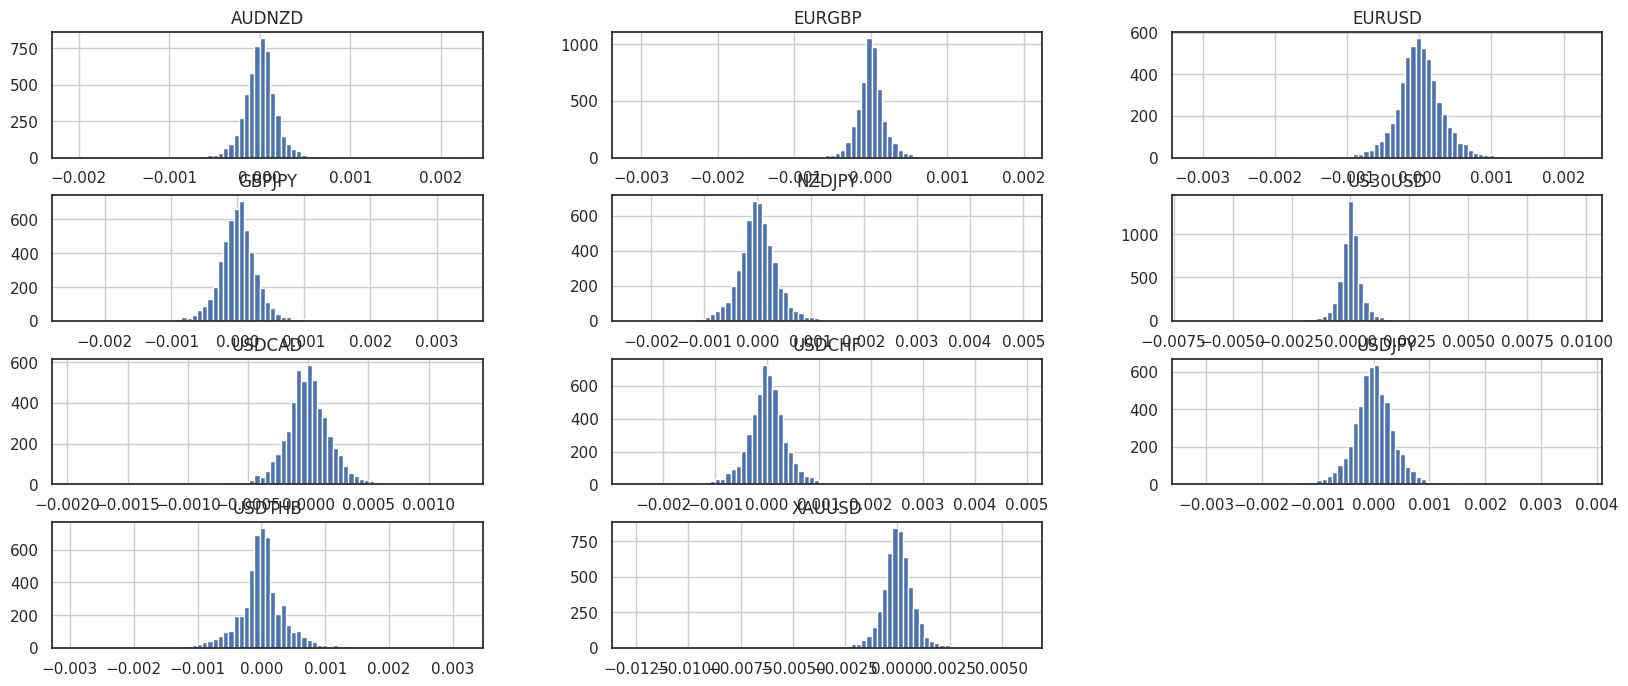

In [60]:
log_return.hist(bins=75, figsize=(20,8))
plt.show()

In [61]:
cum = np.exp(np.cumsum(log_return))

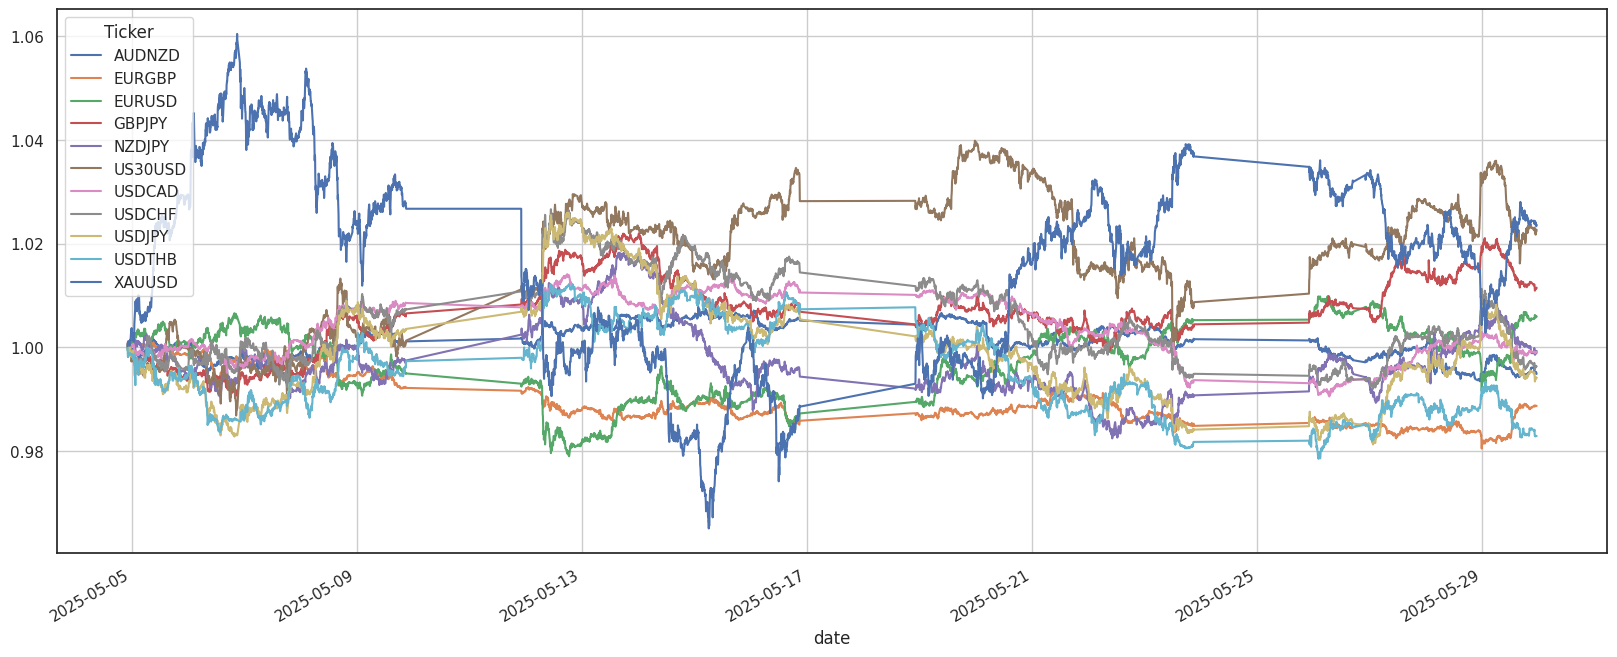

In [62]:

cum.plot(figsize=(20,8))
plt.grid(True)
plt.show()

In [63]:
import pandas as pd
from scipy.stats import kurtosis, skew

# สมมติ df คือ DataFrame ของคุณ

# คำนวณ kurtosis (fisher=True คือแบบ excess kurtosis, ddof=1 คือ sample)
kurt = cum.apply(lambda x: kurtosis(x, fisher=True, nan_policy='omit'))

# คำนวณ skewness
skw = cum.apply(lambda x: skew(x, nan_policy='omit'))

# รวมผลลัพธ์เป็น DataFrame
stats_df = pd.DataFrame({'kurtosis': kurt, 'skewness': skw})

print(stats_df)

         kurtosis  skewness
Ticker                     
AUDNZD  -0.929988 -0.112097
EURGBP  -0.581392  0.748457
EURUSD  -0.551831 -0.497713
GBPJPY  -0.637148 -0.092889
NZDJPY   0.467317  0.759354
US30USD -0.923494 -0.402515
USDCAD  -1.069359 -0.223029
USDCHF  -0.807875  0.522909
USDJPY  -0.162321  0.645397
USDTHB  -1.049362  0.296255
XAUUSD  -0.624861 -0.192503


In [64]:
corr = cum.dropna().corr()

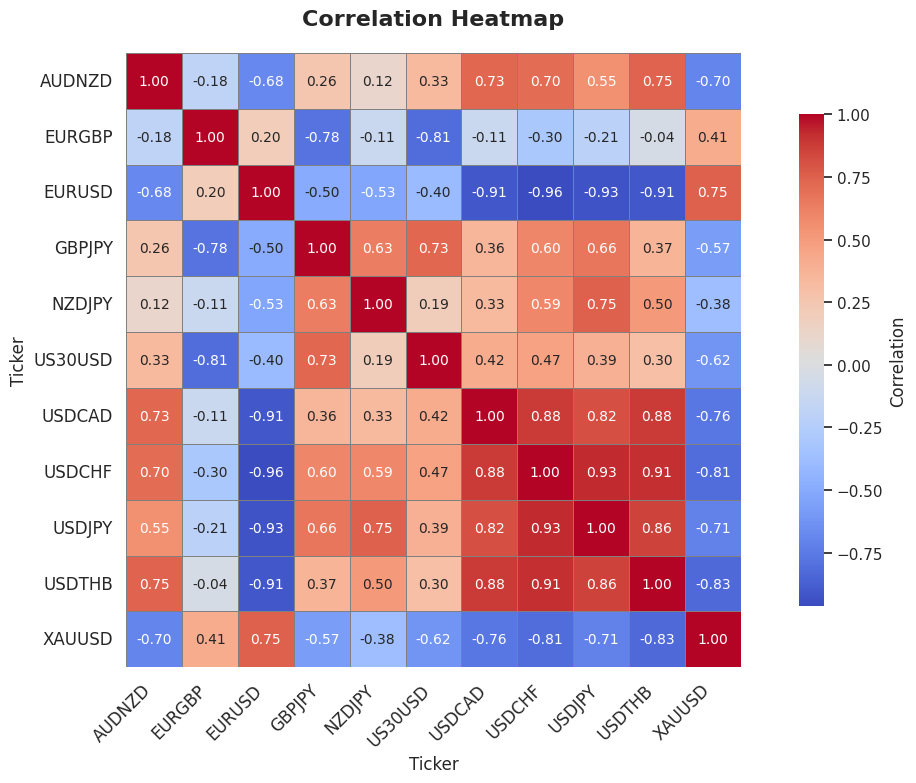

In [65]:
import seaborn as sns


plt.figure(figsize=(12, 8))  # ขนาดรูปใหญ่ขึ้น

sns.set(style="white")  # ธีมสีพื้นหลัง

# สร้าง heatmap
ax = sns.heatmap(
    corr,                    # DataFrame correlation matrix
    annot=True,              # แสดงค่าตัวเลข
    fmt=".2f",               # ทศนิยม 2 ตำแหน่ง
    cmap="coolwarm",         # ชุดสีแดงน้ำเงิน
    linewidths=0.5,          # เส้นแบ่งช่อง
    linecolor='gray',        # สีเส้นแบ่งช่อง
    cbar_kws={"shrink": 0.8, "label": "Correlation"},  # ปรับขนาดและ label ของ colorbar
    square=True,             # ช่องตารางเป็นสี่เหลี่ยมจัตุรัส
    annot_kws={"size": 10}   # ขนาดตัวเลขในตาราง
)

# ปรับ font และ title
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # จัด layout ให้พอดี

plt.show()

In [81]:
from statsmodels.tsa.stattools import coint

results = []
symbols = re.columns.tolist()

import itertools
pairs = list(itertools.combinations(symbols, 2))

for sym1, sym2 in pairs:
    series1 = re[sym1]
    series2 = re[sym2]

    score, pvalue, _ = coint(series1, series2)
    results.append({
        'Stock 1': sym1,
        'Stock 2': sym2,
        'P-Value': pvalue,
        'Test Statistic': score
    })

coint_df = pd.DataFrame(results)
coint_df = coint_df.sort_values('P-Value')
print(coint_df[coint_df['P-Value'] < 0.03])  # คู่ cointegrated

   Stock 1 Stock 2   P-Value  Test Statistic
50  USDCHF  USDTHB  0.008583       -3.945200
25  EURUSD  USDTHB  0.012982       -3.814061
23  EURUSD  USDCHF  0.015658       -3.752622


In [82]:
import statsmodels.api as sm

# สมมุติข้อมูลราคาปิดของ 2 สินทรัพย์
y = re['EURUSD']
x = re['USDCHF']
x = sm.add_constant(x)  # เพิ่มค่าคงที่ให้กับ Linear Regression

model = sm.OLS(y, x).fit()
residual = model.resid  # ดึงค่าคงเหลือ (spread หรือ residual)

In [83]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(residual)
print("ADF Statistic:", adf_result[0])
print("P-Value:", adf_result[1])

ADF Statistic: -3.7522366687518027
P-Value: 0.003435594204294994


In [84]:


def calculate_half_life(residual):
    # สร้าง Lag และ Delta
    lagged_residual = residual.shift(1)
    delta_residual = residual - lagged_residual

    # ลบ NA
    df = pd.DataFrame({'lagged': lagged_residual, 'delta': delta_residual}).dropna()

    # Regression Δresidual ~ residual(-1)
    X = sm.add_constant(df['lagged'])
    model = sm.OLS(df['delta'], X).fit()
    beta = model.params['lagged']

    # คำนวณ Half-life
    half_life = -np.log(2) / beta
    return half_life

In [85]:
# สมมุติ residual_series คือ Series ของ residual ที่คุณมี
half_life = calculate_half_life(residual)
print(f"Half-life: {half_life:.2f} time_frame : {time}")

Half-life: 107.60 time_frame : 5m


In [88]:

def calculate_hedge_ratio(price_y, price_x):
    x = sm.add_constant(price_x)
    model = sm.OLS(price_y, x)
    result = model.fit()
    hedge_ratio = result.params.iloc[1]  # เข้าถึงตำแหน่งด้วย iloc
    return hedge_ratio

In [122]:
hedge_ratio = calculate_hedge_ratio(re['EURUSD'], re['USDCHF'])
print(f"Hedge Ratio: {hedge_ratio:.4f}")

Hedge Ratio: -1.0961


In [90]:


def calculate_spread_and_zscore(price_y, price_x, hedge_ratio, window=60):
    """
    คำนวณ Spread และ Z-Score ของ Spread แบบ Rolling Window

    Parameters:
        price_y (pd.Series): ราคาของหุ้นตัวตั้ง (เช่น EURUSD)
        price_x (pd.Series): ราคาของหุ้นตัว hedge (เช่น NZDJPY)
        hedge_ratio (float): อัตราส่วน hedge ที่คำนวณจาก OLS
        window (int): ขนาด rolling window สำหรับ z-score (ค่าเริ่มต้น = 60)

    Returns:
        spread (pd.Series): ค่าสเปรด
        zscore (pd.Series): ค่า Z-score ของ spread
    """
    spread = price_y - hedge_ratio * price_x
    mean = spread.rolling(window=window).mean()
    std = spread.rolling(window=window).std()
    zscore = (spread - mean) / std
    return spread, zscore

In [123]:
# คำนวณ spread และ z-score
spread, zscore = calculate_spread_and_zscore(re['EURUSD'], re['USDCHF'], hedge_ratio, window=110)

In [124]:
def normalize_series(series):
    return (series - series.mean()) / series.std()

def plot_normalized_prices_and_zscore(df, symbol1, symbol2, spread, zscore):
    norm1 = normalize_series(df[symbol1])
    norm2 = normalize_series(df[symbol2])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # Plot Normalized Prices
    ax1.plot(df.index, norm1, label=f'{symbol1} (Normalized)', color='blue')
    ax1.plot(df.index, norm2, label=f'{symbol2} (Normalized)', color='red')
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax1.set_ylabel('Normalized Price')
    ax1.set_title(f'Normalized Close Prices: {symbol1} vs {symbol2}')
    ax1.legend()
    ax1.grid(True)

    # Plot Z-Score of Spread
    ax2.plot(df.index, zscore, label='Z-Score of Spread', color='purple')
    ax2.axhline(0, color='black', linestyle='--')
    ax2.axhline(2, color='red', linestyle='--', label='Upper Threshold')
    ax2.axhline(-2, color='green', linestyle='--', label='Lower Threshold')
    ax2.set_ylabel('Z-Score')
    ax2.set_title('Z-Score of Spread')
    ax2.legend()
    ax2.grid(True)

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

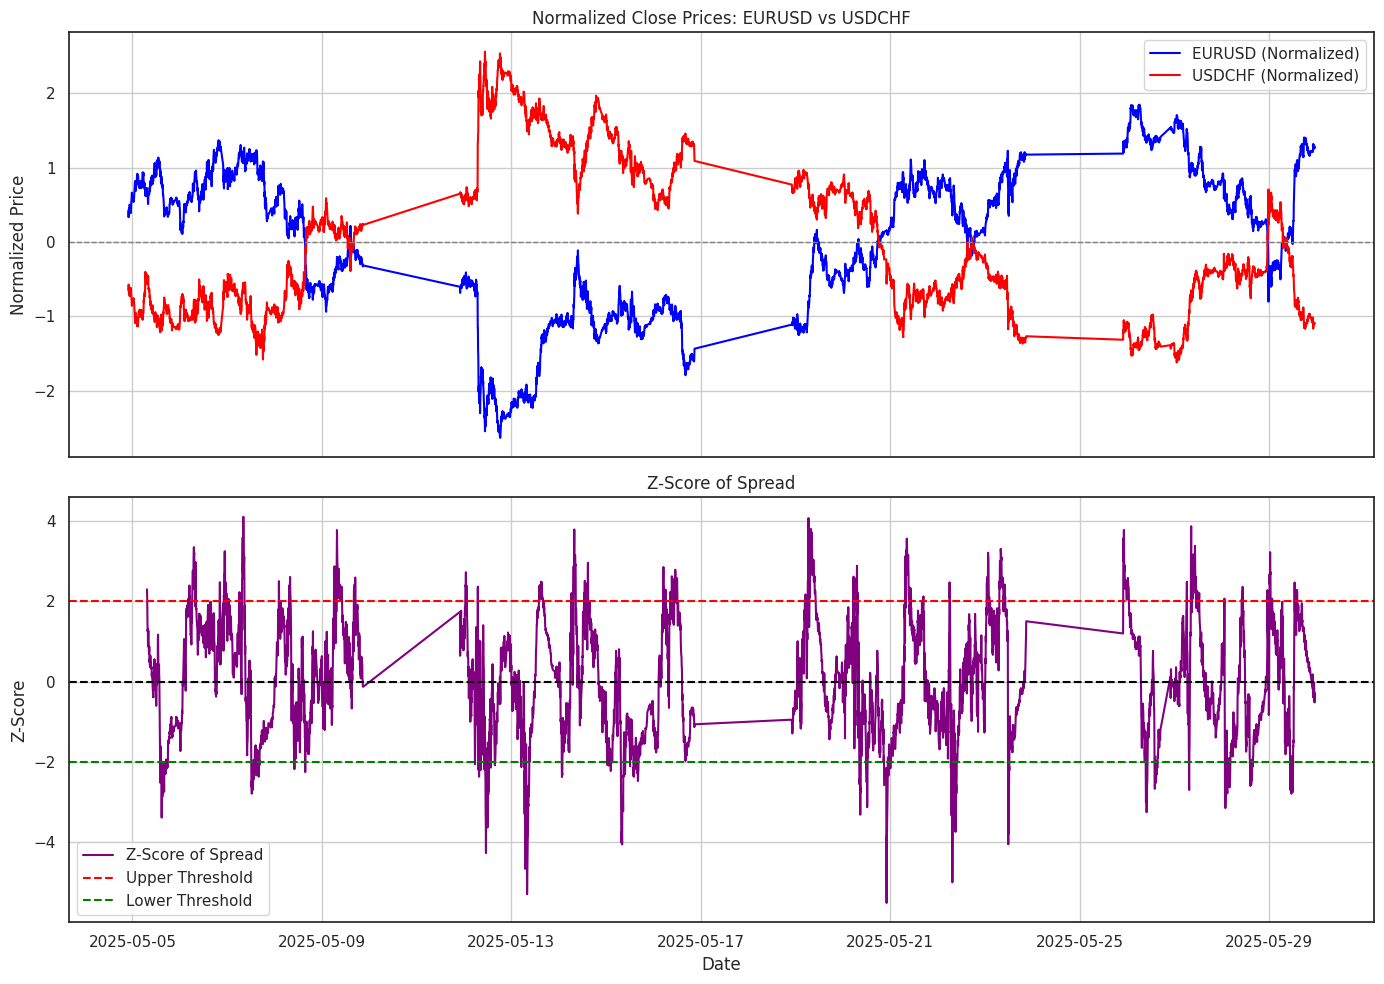

In [115]:
plot_normalized_prices_and_zscore(re, 'EURUSD', 'USDCHF', spread, zscore)